## Data

In [1]:
from data_utils import create_joint_x_y
from sklearn.preprocessing import StandardScaler
import numpy as np

from tqdm.auto import tqdm


num_points_to_generate = 1000
num_latent_points_to_generate = 1000


scaler = StandardScaler()
X, Y = create_joint_x_y(num_points_to_generate)
X_test, Y_test = create_joint_x_y(num_points_to_generate)
# X_scaled = scaler.fit_transform(X)
# X_test_scaled = scaler.transform(X_test)

X_scaled = X
X_test_scaled = X_test

n, d = Y.shape
U = np.random.normal(size=(num_latent_points_to_generate, d))
m = U.shape[0]

nu = np.ones((n, 1)) / n
mu = np.ones((m, 1)) / m

## ICNN 

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch

In [3]:
import sys

sys.path.insert(0, "../")
sys.path.insert(0, "../third_party/cp-flow")

In [4]:
from src.flows import CPFlow

In [5]:
depth = 10
k = 64
lr = 0.001
factor = 0.5
patience = 2000
num_epochs = 20
print_every = 100

batch_size_train = 64
batch_size_test = 64

n_blocks = 4
dimy = d
dimc = X_scaled.shape[1]

device = "cuda:0"

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
X_scaled_tensor = torch.tensor(X_scaled, dtype=torch.float32, device=device)
Y_tensor = torch.tensor(Y, dtype=torch.float32, device=device)

X_test_scaled_tensor = torch.tensor(X_test_scaled, dtype=torch.float32, device=device)
Y_test_tensor = torch.tensor(Y_test, dtype=torch.float32, device=device)

train_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(X_scaled_tensor, Y_tensor),
    batch_size=batch_size_train,
    shuffle=True,
)

test_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(X_test_scaled_tensor, Y_test_tensor),
    batch_size=batch_size_test,
    shuffle=True,
)

In [8]:
flow = CPFlow(
    dim_y=dimy,
    dim_cond=dimc,
    hidden_dim=k,
    num_hidden_layers=depth,
    n_blocks=n_blocks,
    device=device,
)

In [9]:
device_and_dtype_specifications = dict(dtype=torch.float32, device=device)

In [10]:
print(matplotlib.get_backend())

module://matplotlib_inline.backend_inline


In [11]:
flow.fit(
    train_loader=train_loader,
    train_params={
        "num_epochs": num_epochs,
        "batch_size": batch_size_train,
        "lr": lr,
        "print_every": print_every,
    },
)

  0%|          | 0/20 [00:00<?, ?it/s]

init loss: -1.3814104795455933
100 -1.3310753357410432
200 -2.672623683810234
300 -4.01896142065525


In [12]:
# matplotlib.use("QtAgg")

/home/nkotelevskii/github/conditional_quantile_function/vector_quantile_regression/notebooks/../third_party/cp-flow/lib/flows/cpflows.py:164: UserWarning: brute force
  warnings.warn('brute force')


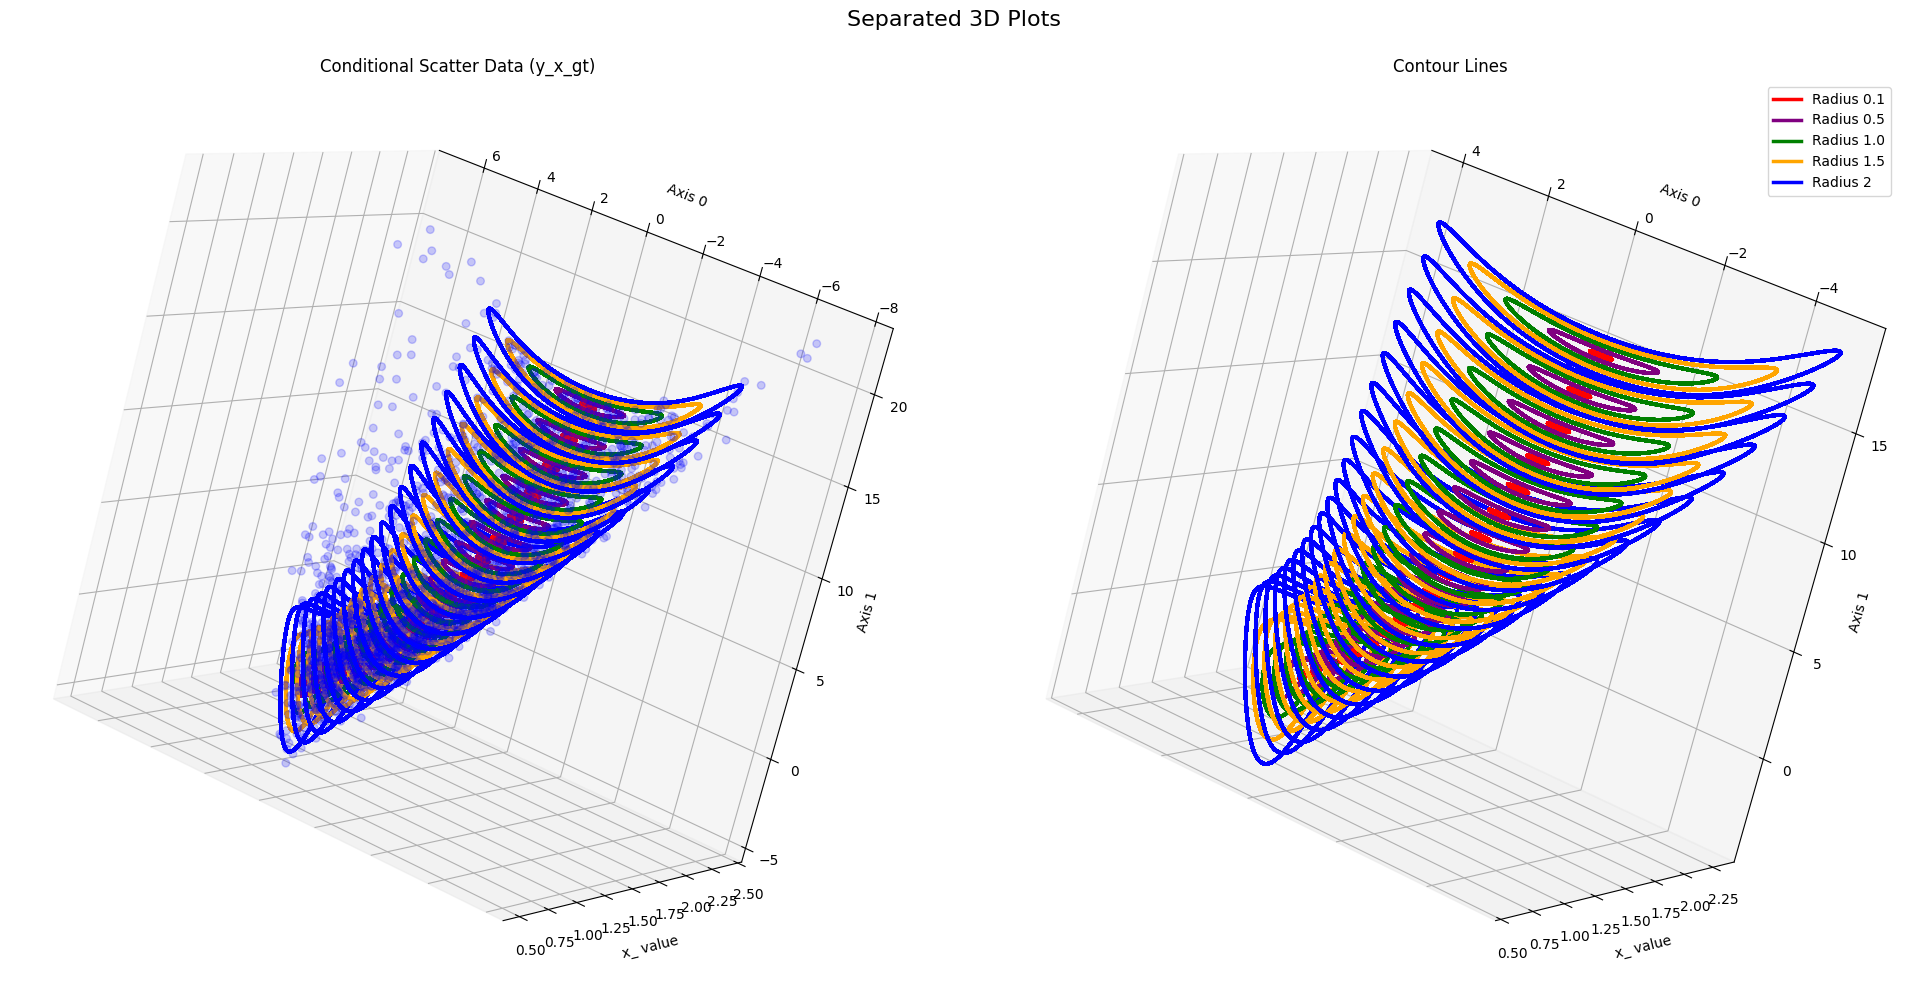

In [13]:
# Change to %matplotlib qt to have interactive plots
%matplotlib inline

from data_utils import create_conditional_x

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10), subplot_kw={"projection": "3d"})
fig.suptitle("Separated 3D Plots", fontsize=16)

ax1.set_title("Conditional Scatter Data (y_x_gt)")
ax1.set_xlabel("Axis 0")
ax1.set_ylabel("Axis 1")
ax1.set_zlabel("x_ value")

for x_ in range(50, 250, 10):
    x = np.array([x_ / 100])[:, None]

    # This section is now active for the first plot
    _, y_x_gt = create_conditional_x(n_points=100, x_value=x_ / 100)
    z_scatter = np.full(y_x_gt.shape[0], x)
    ax1.scatter(
        y_x_gt[:, 0], y_x_gt[:, 1], z_scatter, color="blue", marker="o", s=30, alpha=0.2
    )

ax1.view_init(elev=-55, azim=154, roll=-83)

ax2.set_title("Contour Lines")
ax2.set_xlabel("Axis 0")
ax2.set_ylabel("Axis 1")
ax2.set_zlabel("x_ value")

loop_start_value = 50
for x_ in range(loop_start_value, 250, 10):
    x = torch.tensor([x_ / 100], **device_and_dtype_specifications)[:, None]
    x = x.repeat(repeats=(100, 1))

    colors = ["red", "purple", "green", "orange", "blue"]
    radii = [0.1, 0.5, 1.0, 1.5, 2]
    for contour_radius, color in zip(radii, colors):
        pi_tensor = torch.linspace(-torch.pi, torch.pi, 100)
        u_tensor = torch.stack(
            [
                contour_radius * torch.cos(pi_tensor),
                contour_radius * torch.sin(pi_tensor),
            ],
            dim=1,
        )

        u_tensor = u_tensor.to(**device_and_dtype_specifications)
        u_tensor.requires_grad = True

        pushforward_of_u = flow.reverse_transform(u_tensor, cond=x).cpu()

        z_line = x.detach().cpu().numpy()
        label = f"Radius {contour_radius}" if x_ == loop_start_value else ""
        ax1.plot(
            pushforward_of_u[:, 0],
            pushforward_of_u[:, 1],
            z_line,
            color=color,
            linewidth=2.5,
            label=label,
        )
        ax2.plot(
            pushforward_of_u[:, 0],
            pushforward_of_u[:, 1],
            z_line,
            color=color,
            linewidth=2.5,
            label=label,
        )

ax2.view_init(elev=-55, azim=154, roll=-83)
ax2.legend()

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to make room for suptitle
plt.show()

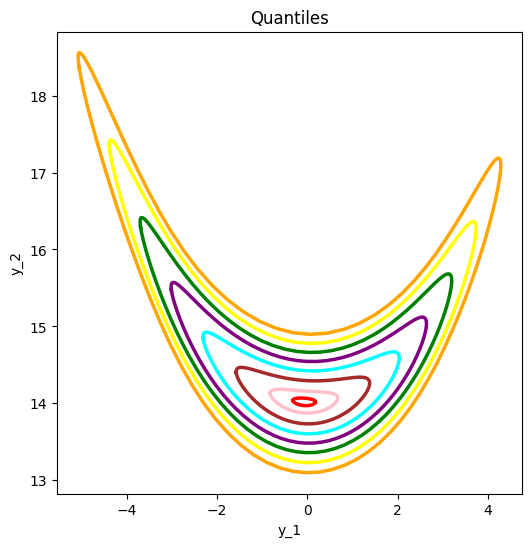

In [14]:
# Change to %matplotlib qt to have interactive plots
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(1, 1, figsize=(6, 6))

ax1.set_title("Quantiles")
ax1.set_xlabel("y_1")
ax1.set_ylabel("y_2")
x = torch.tensor([2.4], **device_and_dtype_specifications)[:, None]
x = x.repeat(u_tensor.shape[0], 1)


colors = ["red", "pink", "brown", "cyan", "purple", "green", "yellow", "orange"]
radii = [0.1, 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 5]
for contour_radius, color in zip(radii, colors):
    pi_tensor = torch.linspace(-torch.pi, torch.pi, 100)
    u_tensor = torch.stack(
        [
            contour_radius * torch.cos(pi_tensor),
            contour_radius * torch.sin(pi_tensor),
        ],
        dim=1,
    )

    u_tensor = u_tensor.to(**device_and_dtype_specifications)
    u_tensor.requires_grad = True
    pushforward_of_u = flow.reverse_transform(u_tensor, cond=x).cpu()

    ax1.plot(pushforward_of_u[:, 0], pushforward_of_u[:, 1], color=color, linewidth=2.5)

# Sample y from the flow 

In [15]:
x = torch.tensor([1.234], dtype=torch.float32, device="cuda:0")[:, None]

y = flow.sample_y(n_samples=1000, cond=x)

densities = torch.exp(flow.logp_cond(y, cond=x)).cpu()
normalized_points = flow.forward_transform(y, cond=x).cpu()
y = y.cpu()

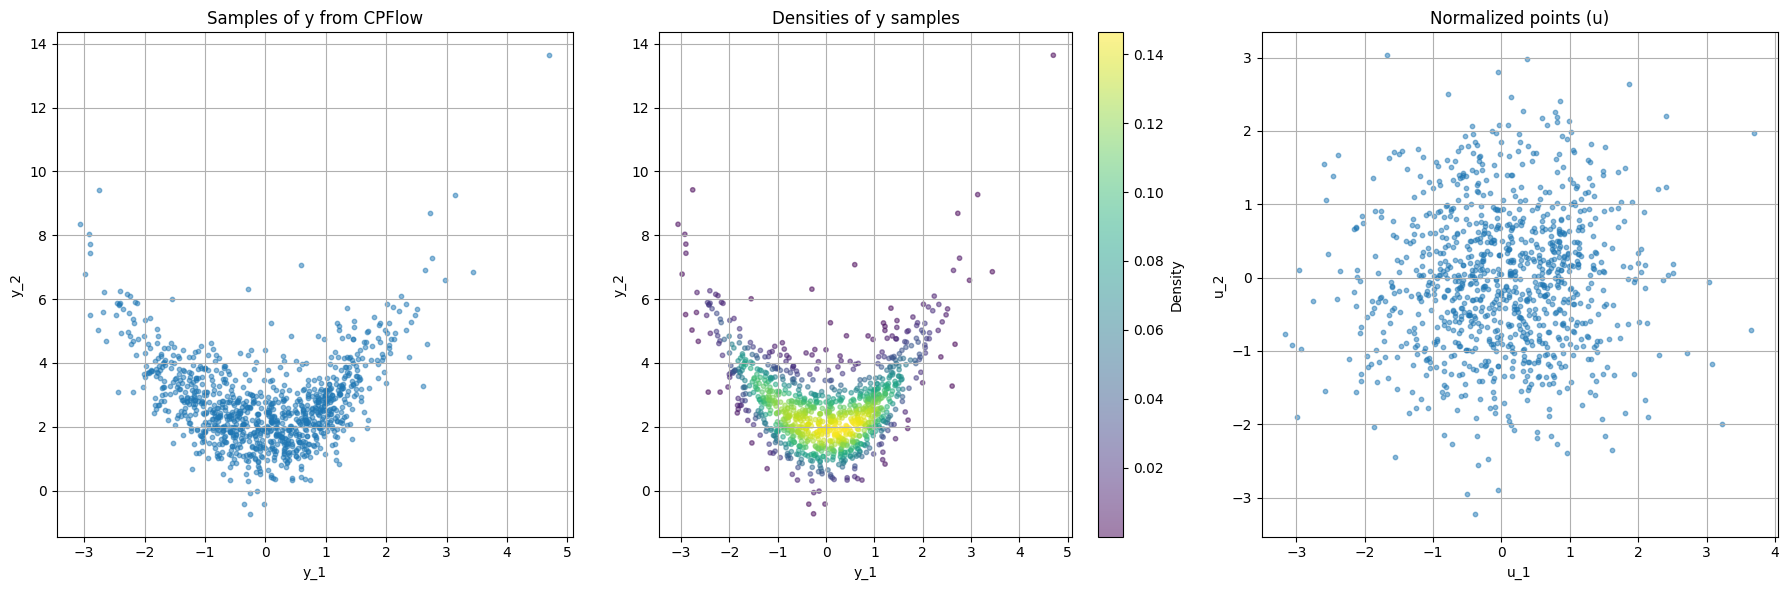

In [16]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

# Left: y samples
ax1.scatter(y[:, 0], y[:, 1], alpha=0.5, s=10)
ax1.set_title("Samples of y from CPFlow")
ax1.set_xlabel("y_1")
ax1.set_ylabel("y_2")
ax1.grid(True)

# Middle: densities as color
sc = ax2.scatter(
    y[:, 0], y[:, 1], c=densities.detach().numpy(), cmap="viridis", alpha=0.5, s=10
)
ax2.set_title("Densities of y samples")
ax2.set_xlabel("y_1")
ax2.set_ylabel("y_2")
ax2.grid(True)
plt.colorbar(sc, ax=ax2, label="Density")

# Right: normalized points
ax3.scatter(
    normalized_points[:, 0], normalized_points[:, 1], alpha=0.5, s=10, color="tab:blue"
)
ax3.set_title("Normalized points (u)")
ax3.set_xlabel("u_1")
ax3.set_ylabel("u_2")
ax3.grid(True)

plt.tight_layout()
plt.show()